Importo la librerías que vamos a utilizar

In [12]:
import numpy as np  #cálculo numérico
import sympy as smp  #cálculo simbólico
from sympy import init_printing  
from scipy.integrate import odeint  #resolución de ODEs
import matplotlib.pyplot as plt  #gráficos
from matplotlib import animation  #animación 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

Defino las variables simbólicamente para usarlas despues en el lagrangiano

In [13]:
t, g = smp.symbols('t g')
m1, m2 = smp.symbols('m1 m2')
l = smp.symbols('l')

$\theta_1$ es mi coordenada generalizada. La misma es una funcion del tiempo asi que las defino simbolicamente como funcion del tiempo.

In [14]:
the1 = smp.symbols(r'\theta_1', cls=smp.Function)
the1 = the1(t)
the1

\theta_1(t)

Calculo $\dot{\theta_1}$ y $\dot{\theta_2}$

In [15]:
the1_d = smp.diff(the1, t)
the1_dd = smp.diff(the1_d, t)

Escribo las coordenadas cartesianas de las posiciones de las masas $m_1$ y $m_2$ en función de $\theta_1$.

In [16]:
x1 = l * smp.sin(the1) 
y1= 0
x2 = 0
y2 = - l*smp.cos(the1)

Escribo el lagrangiano del sistema, escribiendo la cinetica y potencial de cada partícula.

In [17]:
# Cinética
T = 1/2 * m1 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2) + 1/2 * m2 * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2)
# Potencial
V =  m1*g*y2
# Lagrangiano
L = T-V

Escribo las ecuaciones de Euler-Lagrange:

In [18]:
LE= smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t).simplify()


Resuelvo simbolicamente (toma la ecuacion y la iguala a 0 )

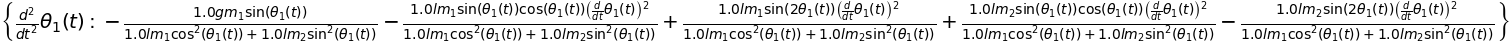

In [20]:
sols = smp.solve([LE], (the1_dd),
                simplify=False, rational=False)
sols

Ahora que tenemos las soluciones, podemos resolverlas **numericamente**.
Para transformarlas en EDOs de primer orden defino $z = d\theta/dt$
Luego usamos smp.lambdify para pasar lo simbolico a numérico

In [21]:
dz1dt_f = smp.lambdify((t,g,m1,m2,l,the1,the1_d), sols[the1_dd])
dthe1dt_f = smp.lambdify(the1_d, the1_d)

Para resolver ODEs en python se define al vector S, en este caso $\vec{S} = (\theta_1, z1)$
Luego, necesitamos definir $d\vec{S}/dt(\vec{S},t)$

In [22]:
def dSdt(S, t, g, m1, m2, l):
    the1, z1 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t, g, m1, m2, l, the1, z1),
    ]

Le doy valor a los parametros del problema y resuelvo con odeint


In [23]:
t = np.linspace(0, 40, 1001)
g = 9.81 #m/s^2
m1=2  #kg
m2=2  #kg
l = 2  #m
ans = odeint(dSdt, y0=[0.5, -0.5], t=t, args=(g,m1,m2,l))
ans

array([[ 0.5       , -0.5       ],
       [ 0.47814284, -0.5922274 ],
       [ 0.45267683, -0.68032894],
       ...,
       [ 0.38840548,  0.84865172],
       [ 0.42082544,  0.77137151],
       [ 0.45004155,  0.6885675 ]])

obtengo $\theta_1(t)$

In [26]:
the1 = ans.T[0]

La próxima es una función que toma $\theta_1(t)$ y devuelve la posición en $(x,y)$ de las dos masas.

In [27]:
def get_x1y1x2y2(t, the1,l):
    return (l * np.sin(the1) ,
            np.zeros(len(the1)),
            np.zeros(len(the1)),
           - l*np.cos(the1))

x1, y1, x2, y2 = get_x1y1x2y2(t, ans.T[0], l)

Finalmente, realizamos la animación del problema dadas las condiciones iniciales.

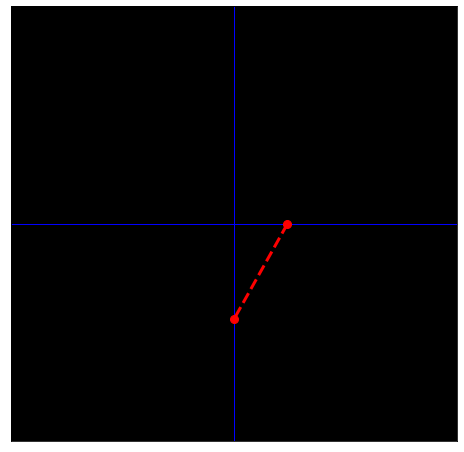

In [28]:
def animate(i):
    ln1.set_data([x1[i], x2[i]], [y1[i], y2[i]]) #seteo el origen y las coordenadas de las partículas
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # para que no se vean los ejes
ax.get_yaxis().set_ticks([]) 
ax.hlines(y=0, xmin=-4, xmax=4, linewidth=1, color='b')
ax.vlines(x = 0,ymin = -4, ymax = 4, linewidth=1, color='b')
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)

In [29]:
from IPython.display import HTML
HTML(ani.to_html5_video())